In [1]:
#!/usr/bin/env python3
"""
CiNii ArticleのAPIをCSVに
"""

import urllib3
import urllib.parse
import certifi
import pandas as pd
from pandas import Timestamp
import csv
import sys
import json
import time

#APPID = "xxxxx" # APPIDはCiNiiで取得してセット
APPID = "CiNii09-89ef94917d5946d2a0dae832519f760b"
keyword2 = "covid"
keyword = urllib.parse.quote(keyword2)
count = 50

req_url = 'https://ci.nii.ac.jp/opensearch/search?format=json'
req_url = req_url + "&appid=" + APPID
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())

def req(keyword, start):
   req_url2 = req_url + "&q=" + keyword + "&start=" + str(start) + "&count=" + str(count)
   print(req_url2)
   response = http.request('GET', req_url2)
   json_data = response.data.decode('utf-8')
   time.sleep(0.5)
   return json_data

data_dict1 = json.loads(req(keyword,1))
totalResults = data_dict1["@graph"][0]["opensearch:totalResults"] # 総件数
print("totalResults: ",totalResults)

data_dict = pd.DataFrame()

num = 1
while True:
    json_data2 = req(keyword,num)
    try:
        data_dict = data_dict.append( pd.read_json(json.dumps(json.loads(json_data2)["@graph"][0]["items"])) ,sort="true")
    except Exception:
        pass
    # 
    num = num + count
    if num > int(totalResults) :
        break



https://ci.nii.ac.jp/opensearch/search?format=json&appid=CiNii09-89ef94917d5946d2a0dae832519f760b&q=covid&start=1&count=50
totalResults:  186
https://ci.nii.ac.jp/opensearch/search?format=json&appid=CiNii09-89ef94917d5946d2a0dae832519f760b&q=covid&start=1&count=50
https://ci.nii.ac.jp/opensearch/search?format=json&appid=CiNii09-89ef94917d5946d2a0dae832519f760b&q=covid&start=51&count=50
https://ci.nii.ac.jp/opensearch/search?format=json&appid=CiNii09-89ef94917d5946d2a0dae832519f760b&q=covid&start=101&count=50
https://ci.nii.ac.jp/opensearch/search?format=json&appid=CiNii09-89ef94917d5946d2a0dae832519f760b&q=covid&start=151&count=50


In [2]:
# data_dict.tail()
data_dict['prism:publicationDate'].head()

0    2020-07
1    2020-07
2    2020-07
3    2020-07
4    2020-07
Name: prism:publicationDate, dtype: object

In [3]:
data_dict2 = data_dict.reset_index()
data_dict2['prism:publicationDate2'] = data_dict2['prism:publicationDate'].astype('str')
data_dict2['prism:publicationDate2'] = data_dict2['prism:publicationDate2'].replace('(\d\d\d\d)$', r'\1-00', regex=True)
data_dict2['prism:publicationDate2'] = data_dict2['prism:publicationDate2'].replace('(\d\d\d\d-\d\d)-\d\d$', r'\1', regex=True)
# data_dict2['prism:publicationDate']
# data_dict2
u = data_dict2['prism:publicationDate2'].unique()
print(u)
print(type(u))

['2020-07' '2020-06' '2020-05' '2020-04' '2020-03' '2020-02' '2020-00']
<class 'numpy.ndarray'>


In [4]:
import datetime
data_dict2 = data_dict2.sort_values(by='prism:publicationDate2', ascending=False)
# print(data_dict2)

2020-05     29
2020-07      5
2020-03     11
2020-00    102
2020-06     20
2020-02      2
2020-04     17
Name: prism:publicationDate2, dtype: int64


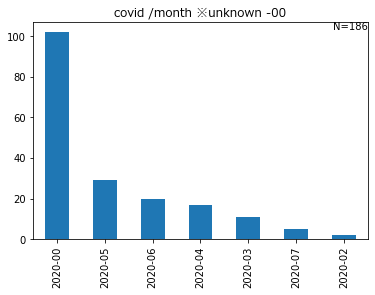

In [15]:
# print(type(data_dict2['prism:publicationDate2'][0]))
# data_dict['prism:publicationDate'] = data_dict['prism:publicationDate'].dt.strftime('%Y-%m') if type(data_dict['prism:publicationDate'][0] ) is Timestamp else 20
# data_dict2['prism:publicationDate'] = data_dict2['prism:publicationDate'].dt.strftime('%Y-%m') if type(data_dict2['prism:publicationDate'].iat[0, 0] ) is datetime else 20
# print(data_dict2['prism:publicationDate'] )
# data_dict2['prism:publicationDate'].plot.bar()
max_range = data_dict2['prism:publicationDate2'].value_counts().max()
# data_dict2['prism:publicationDate2'].value_counts().plot(kind="bar",yticks=list(range(max_range)))
# value_countsで集計すると件数が多い順にソートされる
# data_dict2['prism:publicationDate2'].value_counts(dropna=False).plot(kind="bar", title=keyword2)
ax = data_dict2['prism:publicationDate2'].value_counts().plot(kind="bar") # value_counts(dropna=False)　#, title=keyword2

title = keyword2 + ' /month ※unknown -00'
ax.set_title(title, fontname="Meiryo")
plt.text(  # position text relative to Axes
    1.0, 1.0, 'N='+totalResults,
    ha='right', va='top',
    transform=ax.transAxes
)

fig = ax.get_figure()
fig.savefig('test.png')
# data_dict2['prism:publicationDate'].value_counts(dropna=False).pyticks=[0, 3, 8]lot.bar()
print(data_dict2['prism:publicationDate2'].value_counts(sort=False)) # ascending=True

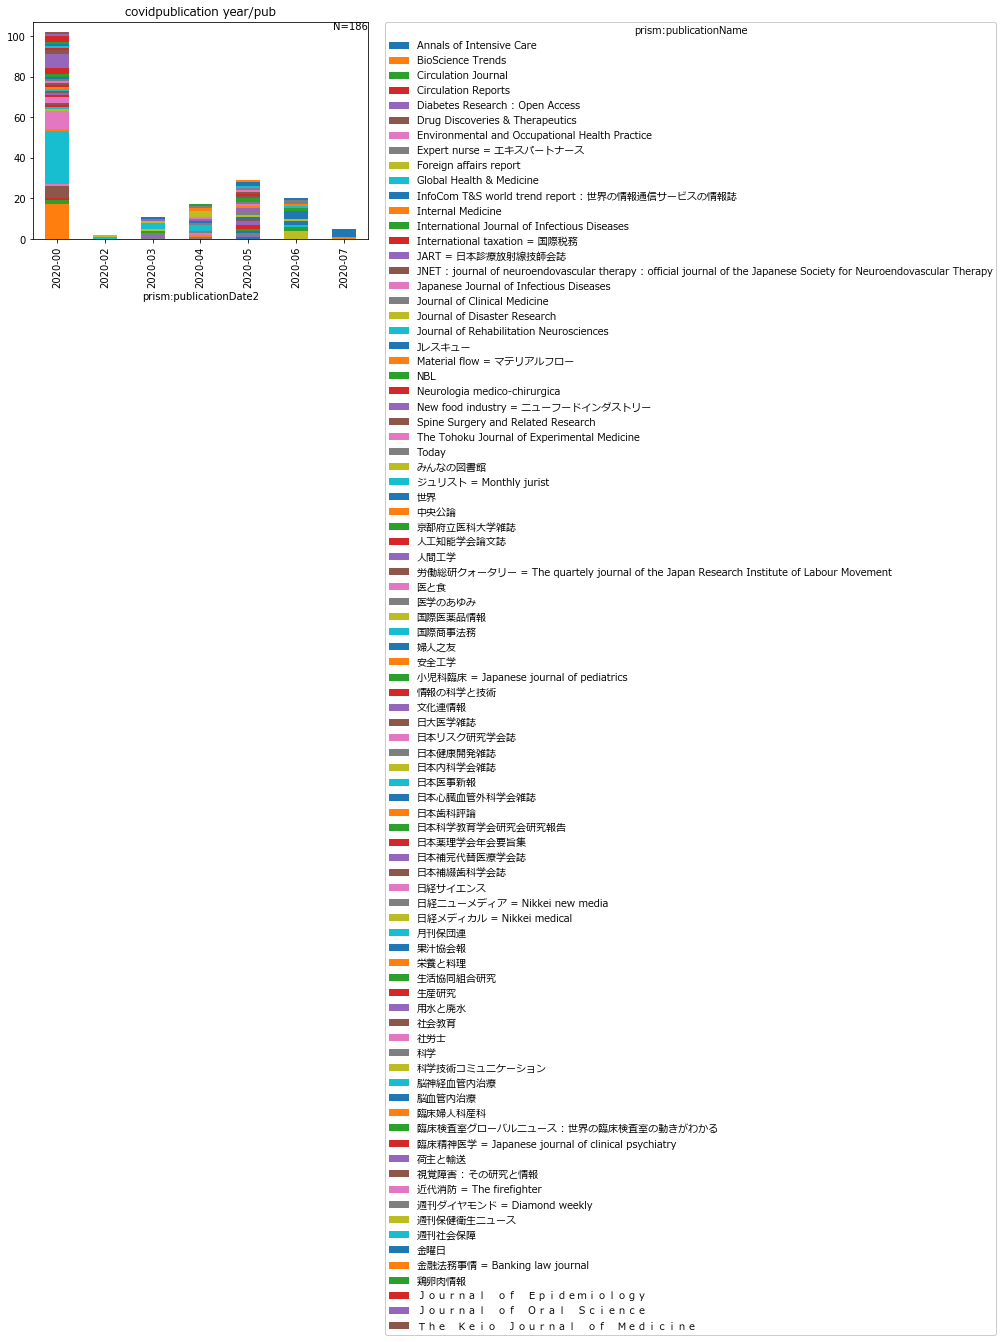

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
data_dict2['prism:publicationName'] = data_dict2['prism:publicationName'].apply(''.join) # list[]をとる
# data_dict2['prism:publicationDate'] = pd.to_datetime(data_dict2['prism:publicationDate'], format='%Y-%m')
# 前のセルで指定していたら不要
# data_dict2['prism:publicationDate'] = data_dict['prism:publicationDate'].dt.strftime('%Y-%m')
cros = pd.crosstab(data_dict2.loc[:,'prism:publicationDate2'],data_dict2.loc[:,'prism:publicationName'])
# print(data_dict2['prism:publicationDate'])
# print(cros)
# stacked=Trueで積み上げ機能オン
crosg = cros.plot.bar(stacked=True)
title = keyword2 + 'publication year/pub'
crosg.set_title(title, fontname="Meiryo")
legend = crosg.legend(framealpha=1.0, prop={"family":"Meiryo"},bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
legend.set_title('prism:publicationName', prop={"family":"Meiryo"})

plt.text(  # position text relative to Axes
    1.0, 1.0, 'N='+totalResults,
    ha='right', va='top',
    transform=crosg.transAxes
)

crosg

0      2020-07
2      2020-07
3      2020-07
4      2020-07
1      2020-07
        ...   
114       2020
113       2020
112       2020
111       2020
185       2020
Name: prism:publicationDate, Length: 186, dtype: object
<class 'str'>


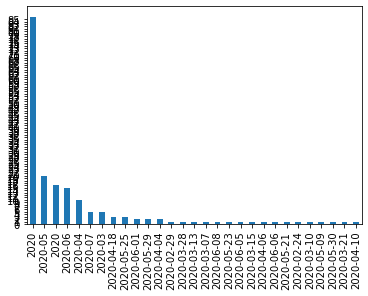

In [7]:
'''
%matplotlib inline
import matplotlib.pyplot as plt
title = keyword2 + 'publication year'
'''
print(data_dict2['prism:publicationDate'])
print(type(data_dict2['prism:publicationDate'][0]))
data_dict['prism:publicationDate'] = data_dict['prism:publicationDate'].dt.strftime('%Y-%m') if type(data_dict['prism:publicationDate'][0] ) is Timestamp else 20
# data_dict2['prism:publicationDate'] = data_dict2['prism:publicationDate'].dt.strftime('%Y-%m') if type(data_dict2['prism:publicationDate'].iat[0, 0] ) is datetime else 20

# print(data_dict2['prism:publicationDate'] )
# data_dict2['prism:publicationDate'].plot.bar()
max_range = data_dict2['prism:publicationDate'].value_counts().max()
data_dict2['prism:publicationDate'].value_counts().plot(kind="bar",yticks=list(range(max_range)))
# data_dict2['prism:publicationDate'].value_counts(dropna=False).pyticks=[0, 3, 8]lot.bar()

In [8]:
import datetime
# data_dict2.sort_values(by='prism:publicationDate')
data_dict2['dcdate2'] = data_dict2['dc:date']
data_dict2['dc:date'] = data_dict2['dc:date'].replace('\-.*', r'', regex=True).astype(int)
# year = ('19' + year).where(year > '50', '20' + year)
# data_dict['prism:publicationDate'] = data_dict['prism:publicationDate'],where(data_dict['prism:publicationDate'],)
# data_dict['prism:publicationDate'].strftime("%Y-%m")
# print(len(data_dict2['prism:publicationDate']))
# data_dict2['prism:publicationDate'] = data_dict2['prism:publicationDate'].replace('(2020)', r'\1-01', regex=True)
data_dict2['prism:publicationDate'] = pd.to_datetime(data_dict2['prism:publicationDate'], format='%Y-%m')
data_dict2.tail(130)

,index,@id,@type,dc:creator,dc:date,dc:publisher,description,link,prism:endingPage,prism:issn,prism:number,prism:pageRange,prism:publicationDate,prism:publicationName,prism:startingPage,prism:volume,rdfs:seeAlso,title,prism:publicationDate2,dcdate2
69,19,https://ci.nii.ac.jp/naid/120006826286,item,"[{'@value': '調 麻佐志'}, {'@value': '鳥谷 真佐子'}, {'...",2020,北海道大学 高等教育推進機構 オープンエデュケーションセンター 科学技術コミュニケーション教...,NaN,{'@id': 'https://ci.nii.ac.jp/naid/120006826286'},30,1881-8390,27.0,NaN,2020-04-01 00:00:00.000000000,科学技術コミュニケーション,21,NaN,{'@id': 'https://ci.nii.ac.jp/naid/12000682628...,システム思考による新型コロナウイルス感染症対策の可視化 : 政府・専門家会議が検査を増やすこ...,2020-04,2020-04
68,18,https://ci.nii.ac.jp/naid/120006849867,item,[{'@value': '種村 剛'}],2020,北海道大学 高等教育推進機構 オープンエデュケーションセンター 科学技術コミュニケーション教...,NaN,{'@id': 'https://ci.nii.ac.jp/naid/120006849867'},50,1881-8390,27.0,NaN,2020-04-01 00:00:00.000000000,科学技術コミュニケーション,39,NaN,{'@id': 'https://ci.nii.ac.jp/naid/12000684986...,新型コロナウイルス感染症抑制のために個人の行動を追跡することの是非 : コンタクト・トレーシ...,2020-04,2020-04
66,16,https://ci.nii.ac.jp/naid/40022209606,item,[{'@value': '武久 徹'}],2020,医学書院,NaN,{'@id': 'https://ci.nii.ac.jp/naid/40022209606'},418,0386-9865,3.0,NaN,2020-04-01 00:00:00.000000000,臨床婦人科産科,416,74.0,{'@id': 'https://ci.nii.ac.jp/naid/40022209606...,Obstetric News 新型コロナウイルス2019感染と妊娠(米国産婦人科学会2019...,2020-04,2020-04
65,15,https://ci.nii.ac.jp/naid/40022217787,item,[{'@value': '関 秀行'}],2020,産業用水調査会,NaN,{'@id': 'https://ci.nii.ac.jp/naid/40022217787'},242,0513-5907,4.0,NaN,2020-04-01 00:00:00.000000000,用水と廃水,237,62.0,{'@id': 'https://ci.nii.ac.jp/naid/40022217787...,塩素処理による新型コロナウイルス「COVID-19」の不活性化,2020-04,2020-04
64,14,https://ci.nii.ac.jp/naid/40022221269,item,[],2020,流通研究社,NaN,{'@id': 'https://ci.nii.ac.jp/naid/40022221269'},104,1342-4599,4.0,NaN,2020-04-01 00:00:00.000000000,Material flow = マテリアルフロー,100,61.0,{'@id': 'https://ci.nii.ac.jp/naid/40022221269...,統計調査REPORT 新型コロナウイルスの影響に関する緊急アンケート調査 日本ロジスティクス...,2020-04,2020-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,14,https://ci.nii.ac.jp/naid/130007848600,item,"[{'@value': 'Cao Guoqing'}, {'@value': 'Tang S...",2020,国立感染症研究所 Japanese Journal of Infectious Diseas...,"&lt;p&gt;In December 2019, a cluster of cases ...",{'@id': 'https://ci.nii.ac.jp/naid/130007848600'},NaN,1344-6304,NaN,NaN,1970-01-01 00:00:00.000002020,Japanese Journal of Infectious Diseases,NaN,NaN,{'@id': 'https://ci.nii.ac.jp/naid/13000784860...,The potential transmission of SARS-CoV-2 from ...,2020-00,2020
113,13,https://ci.nii.ac.jp/naid/130007848605,item,"[{'@value': 'Hu Jianguo'}, {'@value': 'Rao She...",2020,国立感染症研究所 Japanese Journal of Infectious Diseas...,"&lt;p&gt;In December 2019, there was an outbre...",{'@id': 'https://ci.nii.ac.jp/naid/130007848605'},NaN,1344-6304,NaN,NaN,1970-01-01 00:00:00.000002020,Japanese Journal of Infectious Diseases,NaN,NaN,{'@id': 'https://ci.nii.ac.jp/naid/13000784860...,Epidemic characteristics of COVID-19 in four C...,2020-00,2020
112,12,https://ci.nii.ac.jp/naid/130007849461,item,[{'@value': 'Fujishima Seitaro'}],2020,The Keio Journal of Medicine,NaN,{'@id': 'https://ci.nii.ac.jp/naid/130007849461'},NaN,0022-9717,NaN,NaN,1970-01-01 00:00:00.000002020,Ｔｈｅ Ｋｅｉｏ Ｊｏｕｒｎａｌ ｏｆ Ｍｅｄｉｃｉｎｅ,NaN,NaN,{'@id': 'https://ci.nii.ac.jp/naid/13000784946...,COVID-19: Stay Cool toward Corticosteroids,2020-00,2020
111,11,https://ci.nii.ac.jp/naid/130007849484,item,"[{'@value': 'Yoneoka Daisuke'}, {'@value': 'Ku...",2020,日本疫学会,&lt;p&gt;Background&lt;/p&gt;&lt;p&gt;The Worl...,{'@id': 'https://ci.nii.ac.jp/naid/130007849484'},NaN,0917-5040,NaN,NaN,1970-01-01 00:00:00.000002020,Ｊｏｕｒｎａｌ ｏｆ Ｅｐｉｄｅｍｉｏｌｏｇｙ,NaN,NaN,{'@id': 'https://ci.nii.ac.jp/naid/13000784948...,Early SNS-based monitoring system for the COVI...,2020-00,2020


0     2020-07-01 00:00:00.000000000
2     2020-07-01 00:00:00.000000000
3     2020-07-01 00:00:00.000000000
4     2020-07-01 00:00:00.000000000
1     2020-07-01 00:00:00.000000000
                   ...             
114   1970-01-01 00:00:00.000002020
113   1970-01-01 00:00:00.000002020
112   1970-01-01 00:00:00.000002020
111   1970-01-01 00:00:00.000002020
185   1970-01-01 00:00:00.000002020
Name: prism:publicationDate, Length: 186, dtype: datetime64[ns]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


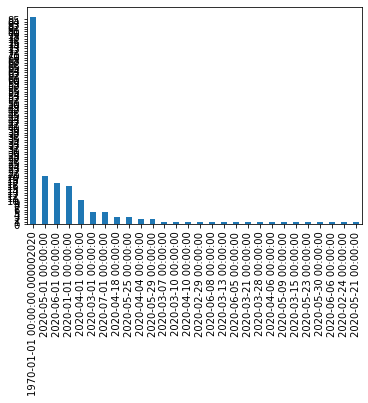

In [9]:
'''
%matplotlib inline
import matplotlib.pyplot as plt
title = keyword2 + 'publication year'
'''
print(data_dict2['prism:publicationDate'])
print(type(data_dict2['prism:publicationDate'][0]))
data_dict['prism:publicationDate'] = data_dict['prism:publicationDate'].dt.strftime('%Y-%m') if type(data_dict['prism:publicationDate'][0] ) is Timestamp else 20
# data_dict2['prism:publicationDate'] = data_dict2['prism:publicationDate'].dt.strftime('%Y-%m') if type(data_dict2['prism:publicationDate'].iat[0, 0] ) is datetime else 20

# print(data_dict2['prism:publicationDate'] )
# data_dict2['prism:publicationDate'].plot.bar()
max_range = data_dict2['prism:publicationDate'].value_counts().max()
data_dict2['prism:publicationDate'].value_counts().plot(kind="bar",yticks=list(range(max_range)))
# data_dict2['prism:publicationDate'].value_counts(dropna=False).pyticks=[0, 3, 8]lot.bar()

0     2020-07-01 00:00:00.000000000
2     2020-07-01 00:00:00.000000000
3     2020-07-01 00:00:00.000000000
4     2020-07-01 00:00:00.000000000
1     2020-07-01 00:00:00.000000000
                   ...             
114   1970-01-01 00:00:00.000002020
113   1970-01-01 00:00:00.000002020
112   1970-01-01 00:00:00.000002020
111   1970-01-01 00:00:00.000002020
185   1970-01-01 00:00:00.000002020
Name: prism:publicationDate, Length: 186, dtype: datetime64[ns]
prism:publicationName          Annals of Intensive Care  BioScience Trends  \
prism:publicationDate                                                        
1970-01-01 00:00:00.000002020                         0                 16   
2020-01-01 00:00:00.000000000                         0                  1   
2020-02-24 00:00:00.000000000                         0                  0   
2020-02-29 00:00:00.000000000                         0                  0   
2020-03-01 00:00:00.000000000                         0                 

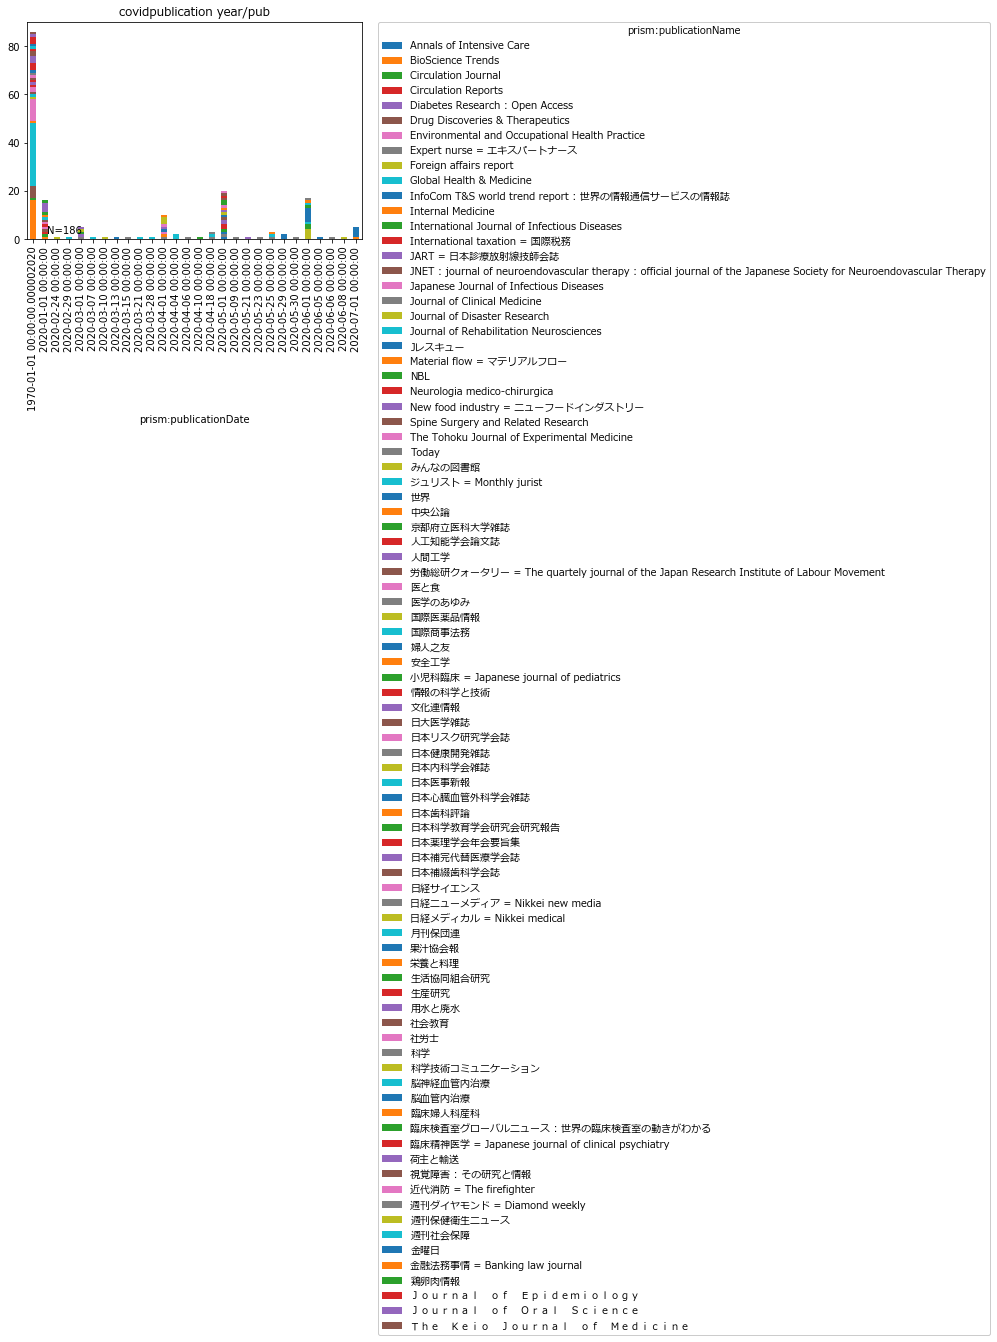

In [10]:
%matplotlib inline
data_dict2['prism:publicationName'] = data_dict2['prism:publicationName'].apply(''.join) # list[]をとる
# data_dict2['prism:publicationDate'] = pd.to_datetime(data_dict2['prism:publicationDate'], format='%Y-%m')
# 前のセルで指定していたら不要
# data_dict2['prism:publicationDate'] = data_dict['prism:publicationDate'].dt.strftime('%Y-%m')
cros = pd.crosstab(data_dict2.loc[:,'prism:publicationDate'],data_dict2.loc[:,'prism:publicationName'])
print(data_dict2['prism:publicationDate'])
print(cros)
# stacked=Trueで積み上げ機能オン
crosg = cros.plot.bar(stacked=True)
title = keyword2 + 'publication year/pub'
crosg.set_title(title, fontname="Meiryo")
legend = crosg.legend(framealpha=1.0, prop={"family":"Meiryo"},bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
# (bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
legend.set_title('prism:publicationName', prop={"family":"Meiryo"})
crosg.text(1.2, 2.3, 'N='+totalResults)
# crosg.legend(["凡例"], prop={"family":"Meiryo"})
crosg

In [11]:
# CSV出力
data_dict.to_csv('cib_data.csv', encoding='utf-8_sig', quoting=csv.QUOTE_ALL, index=False )